In [10]:
# loading data 
import numpy as np

import numpy as np

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# inital parameters 
class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Example parameters from the provided range  I
# I NEED TO DOUBLE CHECK 
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-6
# DEFINE THE MODEL DOUBLE CHECK 
def crr_model(t, y, params, P, Ep):
    # Ensure the index stays within the valid range
    idx = min(int(t), len(P) - 1)
    
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf

    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Define the model parameters
class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initialize example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-6

# Define the model
def crr_model(t, y, params, P, Ep):
    # Ensure the index stays within the valid range
    idx = min(int(t), len(P) - 1)
    
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf

    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(crr_model, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Remove the first two years (730 days)
P = rainfall[730:]
Ep = evaporation[730:]
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]

# Calculate objective functions
F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
F2 = calculate_rmse(Y_sim, Y_obs, P == 0)

F = [F1, F2]
print("Objective functions:", F)

# Define the objective function for DE
def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(crr_model, t_span, initial_conditions, args=(params, P, Ep), t_eval=t_eval)
    Q_sim = solution.y[4]

    # Calculate objective functions
    F1 = calculate_rmse(Q_sim[730:], Y_obs, P > 0)
    F2 = calculate_rmse(Q_sim[730:], Y_obs, P == 0)

    return [F1, F2]

# Parameter bounds
bounds = [(1, 10), (10, 1000), (0, 100), (0, 100), (-10, 10), (0, 10), (0, 150)]




/opt/apps/python/3.10.2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Objective functions: [2693678.92081628, 2690911.7727942984]


In [3]:
def crr_model(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)  # Ensure the index is within bounds
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]


In [4]:
# Example parameters within the given range
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-6

print(f"Initial conditions: {initial_conditions}")
print(f"Parameters: {params.__dict__}")


Initial conditions: [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
Parameters: {'Imax': 5, 'Sumax': 500, 'Qsmax': 50, 'aE': 0.5, 'aF': 1, 'Kf': 2, 'Ks': 50}


In [5]:
# Check the first few rows of the data
print(data[:5, :])

# Check the range and summary statistics of the data
print(f"Rainfall data: min={np.min(rainfall)}, max={np.max(rainfall)}, mean={np.mean(rainfall)}")
print(f"Evaporation data: min={np.min(evaporation)}, max={np.max(evaporation)}, mean={np.mean(evaporation)}")
print(f"Discharge data: min={np.min(discharge)}, max={np.max(discharge)}, mean={np.mean(discharge)}")


[[ 1.9600e+03  1.0000e+00  1.0000e+00  0.0000e+00  6.7000e-01  1.8907e+00
   1.7667e+00 -7.2500e+00]
 [ 1.9600e+03  1.0000e+00  2.0000e+00  1.4530e+01  6.8000e-01  1.8210e+00
   6.0778e+00 -3.1667e+00]
 [ 1.9600e+03  1.0000e+00  3.0000e+00  7.5100e+00  6.8300e-01  2.7863e+00
   9.3833e+00  2.6670e-01]
 [ 1.9600e+03  1.0000e+00  4.0000e+00  2.9000e-01  6.8700e-01  3.2540e+00
   4.5056e+00 -3.6389e+00]
 [ 1.9600e+03  1.0000e+00  5.0000e+00  1.7230e+01  6.9200e-01  2.6072e+00
   3.9889e+00 -1.3778e+00]]
Rainfall data: min=0.0, max=133.98, mean=4.2761439186546735
Evaporation data: min=0.668, max=3.813, mean=2.2436644505279624
Discharge data: min=0.4737, max=31.8432, mean=2.1057508017207662


In [4]:
import numpy as np
from scipy.integrate import solve_ivp

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Print a summary of the results
print("Simulated discharge (first 10 values):", Q_sim[:10])


Simulated discharge (first 10 values): [0.01       0.01626621 0.0240733  0.03280069 0.04208835 0.05172817
 0.06159616 0.07171761 0.08203663 0.09268274]


In [5]:
 def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    Q_sim = solution.y[4]
    
    # Remove the first two years (730 days)
    Y_sim = Q_sim[730:]
    Y_obs = discharge[730:]
    P = rainfall[730:]
    
    # Calculate objective functions
    F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
    F2 = calculate_rmse(Y_sim, Y_obs, P == 0)

    return [F1, F2]



/opt/apps/python/3.10.2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optimal parameters: [8.41327756e+00 3.52505862e+01 9.18438544e+01 5.34326674e-07
 2.06047102e-01 7.32194815e+00 1.24760355e+02]
Objective function values: 3.3481327195498722


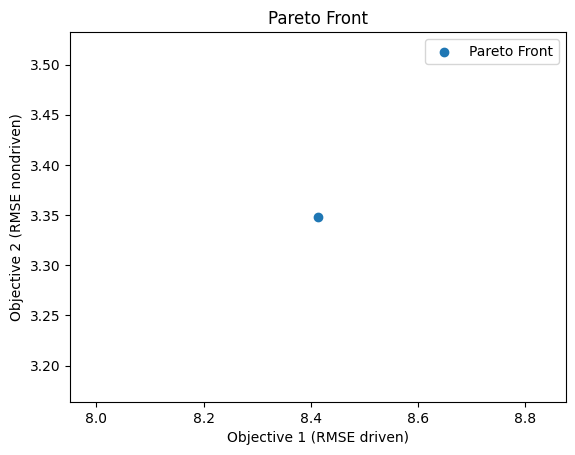

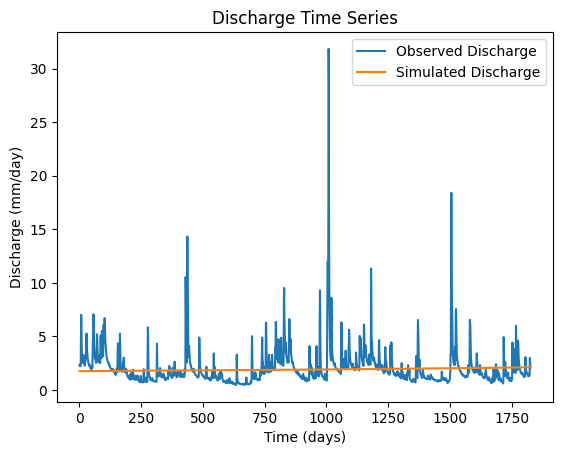

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    Q_sim = solution.y[4]
    
    # Remove the first two years (730 days)
    Y_sim = Q_sim[730:]
    Y_obs = discharge[730:]
    P = rainfall[730:]
    
    # Calculate objective functions
    F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
    F2 = calculate_rmse(Y_sim, Y_obs, P == 0)

    # Combine the two objectives into a single scalar value
    combined_objective = F1 + F2  # You can also use weighted sum, e.g., 0.5*F1 + 0.5*F2

    return combined_objective

# Parameter bounds as per Table 1 (example values, adjust as needed)
bounds = [
    (1, 10),   # Imax
    (10, 1000), # Sumax
    (0, 100),  # Qsmax
    (0, 1),    # aE
    (0, 1),    # aF
    (0.1, 10), # Kf
    (0.1, 150) # Ks
]

# Set the population size and number of generations
population_size = 20
generations = 50

# Perform Differential Evolution
result = differential_evolution(objective_function, bounds, popsize=population_size, maxiter=generations)

print("Optimal parameters:", result.x)
print("Objective function values:", result.fun)

# Final Pareto solution set in the objective function space
plt.scatter(result.x[0], result.fun, label='Pareto Front')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Time-series plot
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*result.x), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series')
plt.show()



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  3.5435575310 |         ideal
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  0.000000E+00 |             f
    11 |      200 |      1 |  0.000000E+00 |             f
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  3.404180E+01 |         ideal
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |      1 |  0.000000E+00 |             f
    16 |      250 |      1 |  0.000000E+00 |            

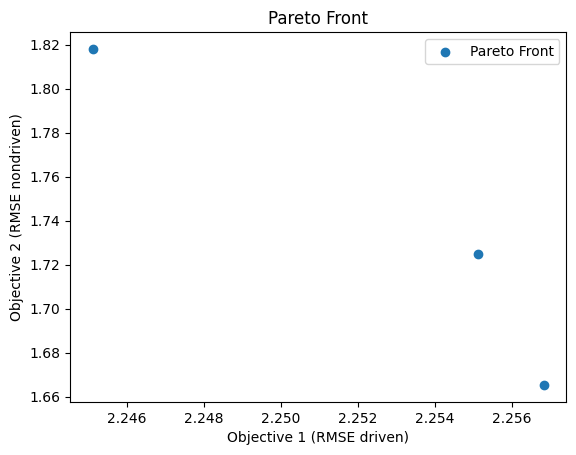

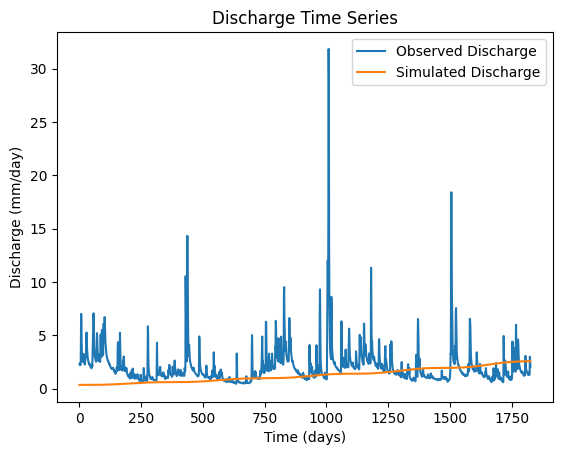

In [2]:
# Ensure pymoo is installed (this line should be run only once)


import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

# Create the problem instance
problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series')
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  1.016204E+02 |         ideal
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  3.433967E+02 |         ideal
    11 |      200 |      1 |  2.013591E+02 |         ideal
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  0.000000E+00 |             f
    14 |      230 |      1 |  2.278354E+02 |         ideal
    15 |      240 |      1 |  0.000000E+00 |             f
    16 |      250 |      1 |  0.000000E+00 |            

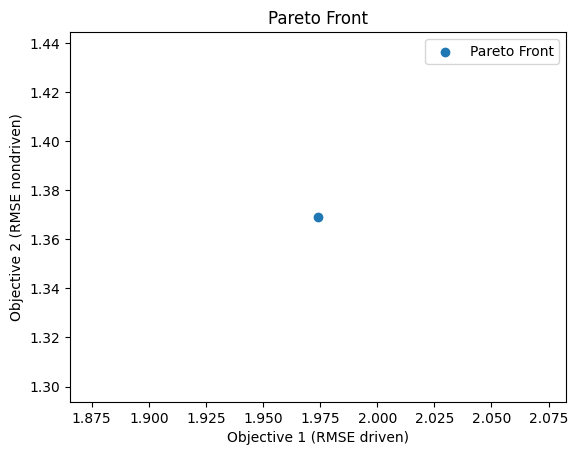

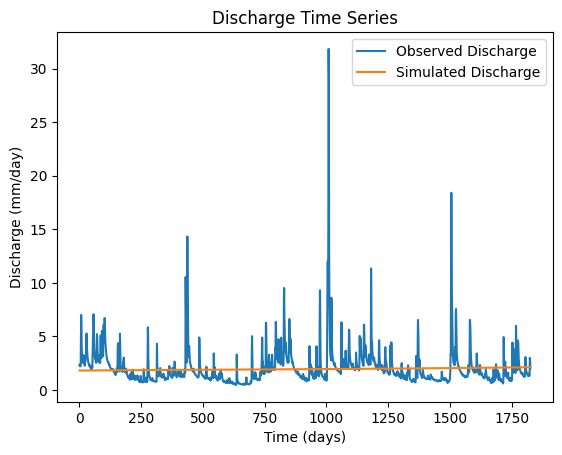

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

# Create the problem instance
problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series')
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  0.000000E+00 |             f
    11 |      200 |      1 |  1.048213E+03 |         ideal
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  4.517765E+01 |         ideal
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |      1 |  0.000000E+00 |             f
    16 |      250 |      1 |  0.000000E+00 |            

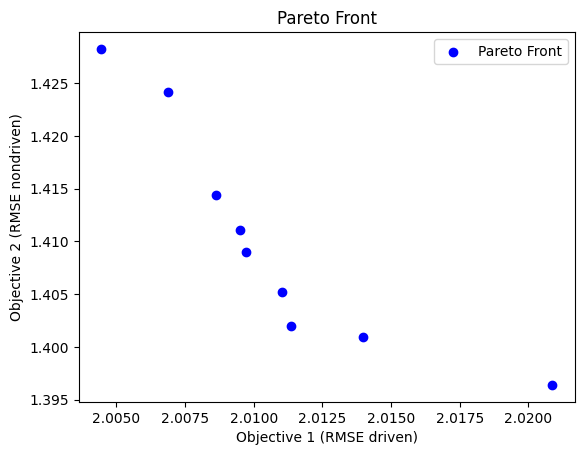

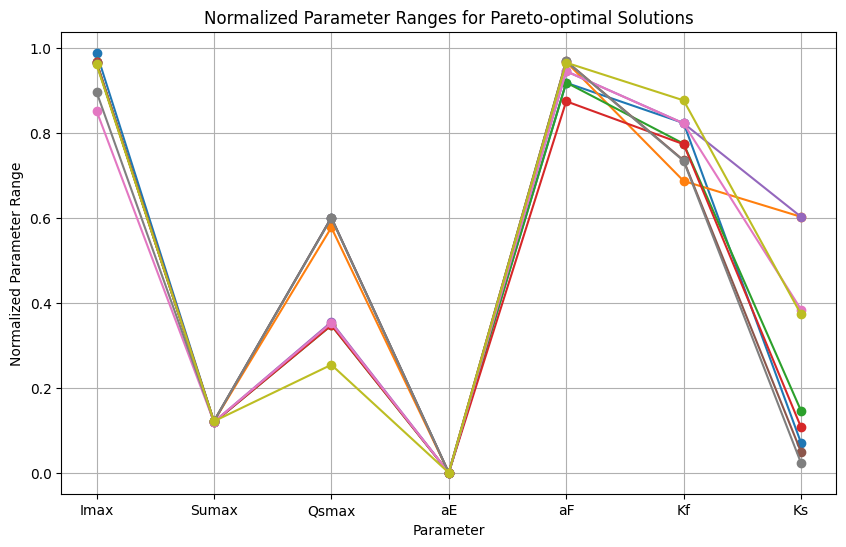

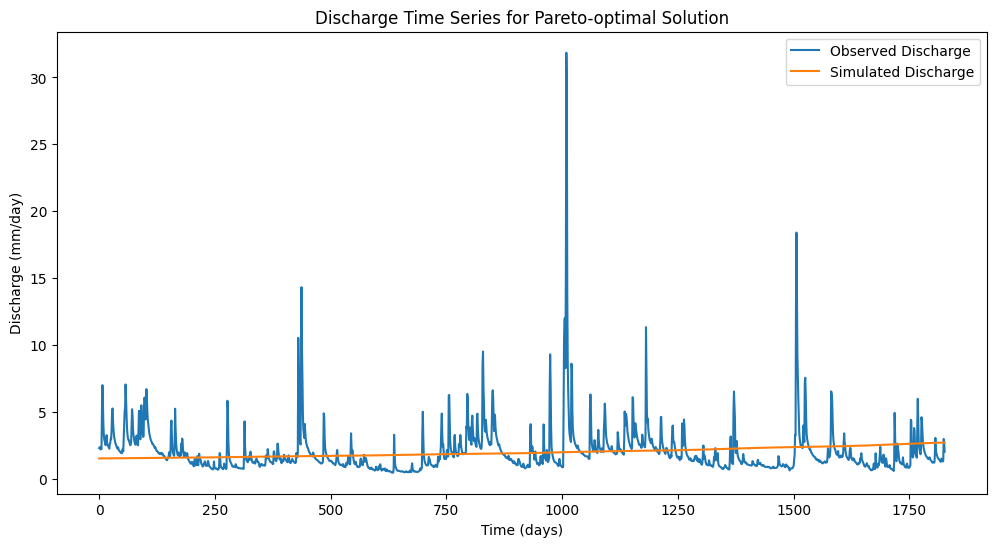

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

# Create the problem instance
problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front in the objective function space
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='b')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Normalize the parameter ranges for visualization
parameter_labels = ['Imax', 'Sumax', 'Qsmax', 'aE', 'aF', 'Kf', 'Ks']
normalized_pareto_solutions = (pareto_solutions - np.array([1, 10, 0, 0, 0, 0.1, 0.1])) / np.array([9, 990, 100, 1, 1, 9.9, 149.9])

# Plot the normalized parameter ranges similar to Figure 6(A)
plt.figure(figsize=(10, 6))
for solution in normalized_pareto_solutions:
    plt.plot(parameter_labels, solution, marker='o')
plt.xlabel('Parameter')
plt.ylabel('Normalized Parameter Range')
plt.title('Normalized Parameter Ranges for Pareto-optimal Solutions')
plt.grid(True)
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.figure(figsize=(12, 6))
plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series for Pareto-optimal Solution')
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  4.394027E+02 |         ideal
    11 |      200 |      1 |  2.205163E+01 |         ideal
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  0.000000E+00 |             f
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |      1 |  0.000000E+00 |             f
    16 |      250 |      1 |  0.000000E+00 |            

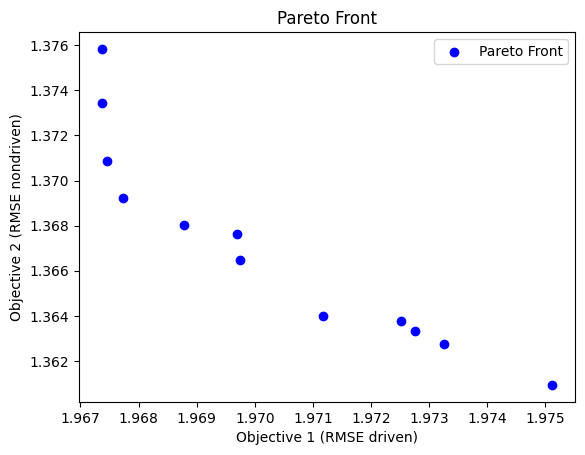

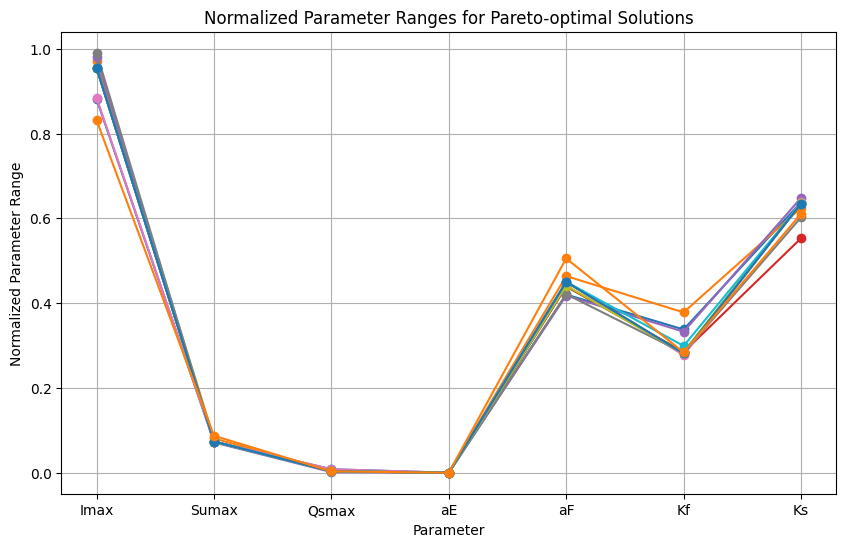

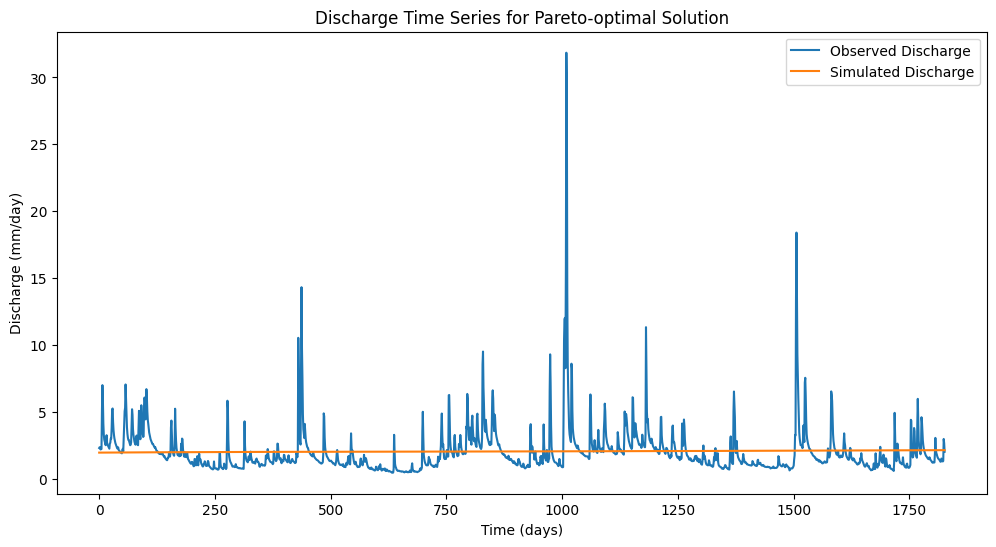

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

# Create the problem instance
problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front in the objective function space
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='b')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Normalize the parameter ranges for visualization
parameter_labels = ['Imax', 'Sumax', 'Qsmax', 'aE', 'aF', 'Kf', 'Ks']
normalized_pareto_solutions = (pareto_solutions - np.array([1, 10, 0, 0, 0, 0.1, 0.1])) / np.array([9, 990, 100, 1, 1, 9.9, 149.9])

# Plot the normalized parameter ranges similar to Figure 6(A)
plt.figure(figsize=(10, 6))
for solution in normalized_pareto_solutions:
    plt.plot(parameter_labels, solution, marker='o')
plt.xlabel('Parameter')
plt.ylabel('Normalized Parameter Range')
plt.title('Normalized Parameter Ranges for Pareto-optimal Solutions')
plt.grid(True)
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.figure(figsize=(12, 6))
plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series for Pareto-optimal Solution')
plt.show()


Mean Bias Error (Driven): 17162.39895615944
Mean Bias Error (Non-Driven): 17335.362941075095
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  1.225659E+03 |         ideal
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  2.219553E+02 |         ideal
    11 |      200 |      1 |  1.160166E+02 |         ideal
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  0.000000E+00 |             f
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |   

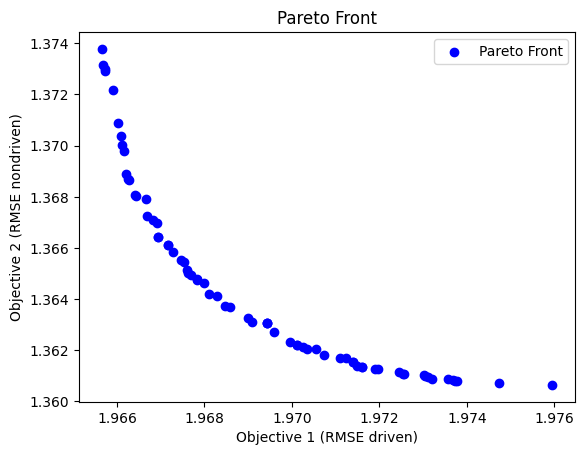

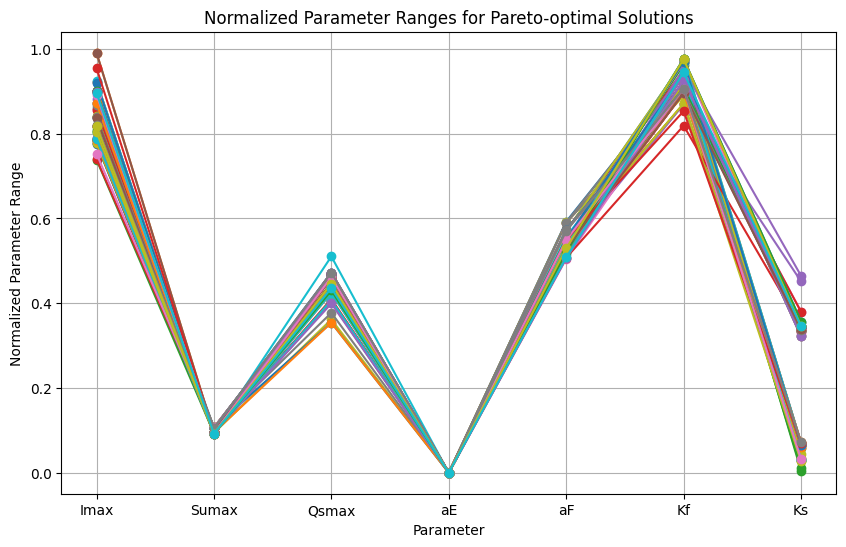

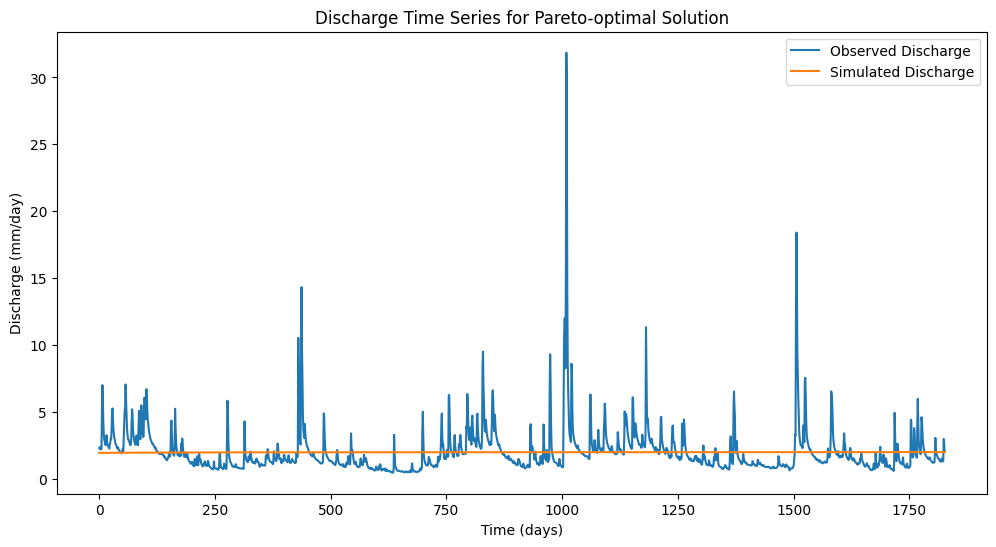

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Function to calculate Mean Bias Error (MBE)
def calculate_mbe(simulated, observed):
    return np.mean(simulated - observed)

# Calculate MBE for the driven and non-driven parts
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]
P = rainfall[730:]

mbe_driven = calculate_mbe(Y_sim[P > 0], Y_obs[P > 0])
mbe_nondriven = calculate_mbe(Y_sim[P == 0], Y_obs[P == 0])

print(f"Mean Bias Error (Driven): {mbe_driven}")
print(f"Mean Bias Error (Non-Driven): {mbe_nondriven}")

# Create the problem instance
class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front in the objective function space
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='b')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Normalize the parameter ranges for visualization
parameter_labels = ['Imax', 'Sumax', 'Qsmax', 'aE', 'aF', 'Kf', 'Ks']
normalized_pareto_solutions = (pareto_solutions - np.array([1, 10, 0, 0, 0, 0.1, 0.1])) / np.array([9, 990, 100, 1, 1, 9.9, 149.9])

# Plot the normalized parameter ranges similar to Figure 6(A)
plt.figure(figsize=(10, 6))
for solution in normalized_pareto_solutions:
    plt.plot(parameter_labels, solution, marker='o')
plt.xlabel('Parameter')
plt.ylabel('Normalized Parameter Range')
plt.title('Normalized Parameter Ranges for Pareto-optimal Solutions')
plt.grid(True)
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.figure(figsize=(12, 6))
plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Y_sim, label='Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series for Pareto-optimal Solution')
plt.show()


Mean Bias Error (Driven): 17162.39895615944
Mean Bias Error (Non-Driven): 17335.362941075095
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  8.515931E+01 |         ideal
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      190 |      1 |  3.973722E+01 |         ideal
    11 |      200 |      1 |  0.000000E+00 |             f
    12 |      210 |      1 |  8.952971E+02 |         ideal
    13 |      220 |      1 |  1.241323E+03 |         ideal
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |   

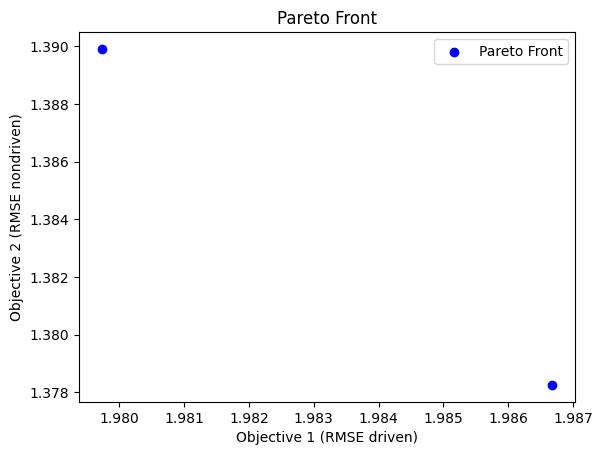

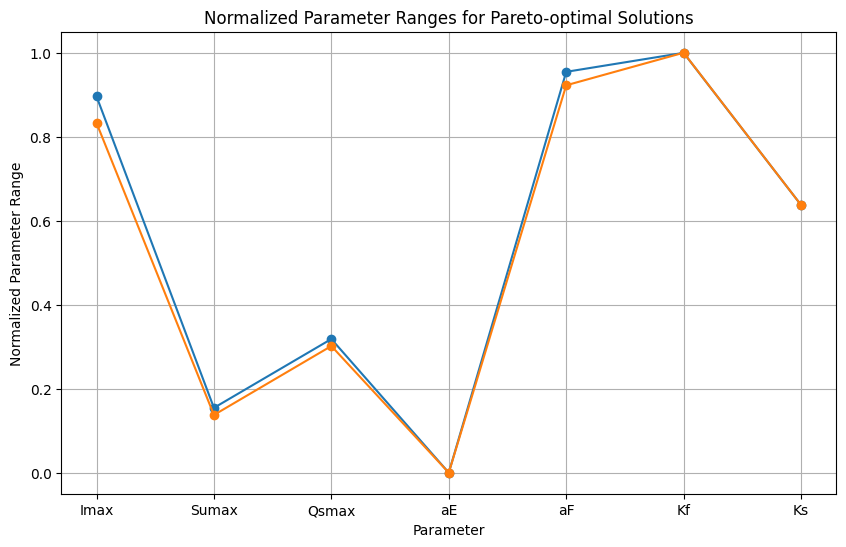

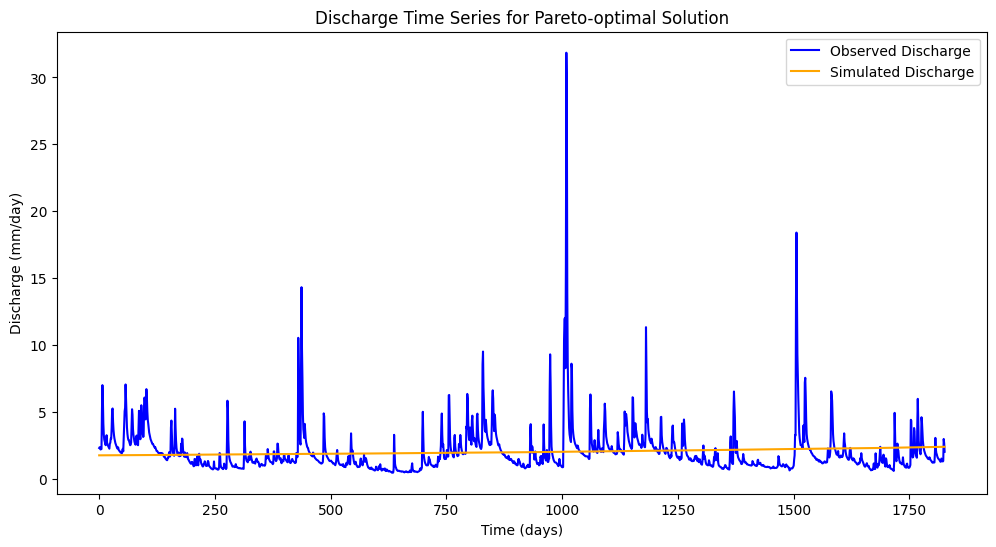

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Function to calculate Mean Bias Error (MBE)
def calculate_mbe(simulated, observed):
    return np.mean(simulated - observed)

# Calculate MBE for the driven and non-driven parts
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]
P = rainfall[730:]

mbe_driven = calculate_mbe(Y_sim[P > 0], Y_obs[P > 0])
mbe_nondriven = calculate_mbe(Y_sim[P == 0], Y_obs[P == 0])

print(f"Mean Bias Error (Driven): {mbe_driven}")
print(f"Mean Bias Error (Non-Driven): {mbe_nondriven}")

# Create the problem instance
class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front in the objective function space
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='b')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Normalize the parameter ranges for visualization
parameter_labels = ['Imax', 'Sumax', 'Qsmax', 'aE', 'aF', 'Kf', 'Ks']
normalized_pareto_solutions = (pareto_solutions - np.array([1, 10, 0, 0, 0, 0.1, 0.1])) / np.array([9, 990, 100, 1, 1, 9.9, 149.9])

# Plot the normalized parameter ranges similar to Figure 6(A)
plt.figure(figsize=(10, 6))
for solution in normalized_pareto_solutions:
    plt.plot(parameter_labels, solution, marker='o')
plt.xlabel('Parameter')
plt.ylabel('Normalized Parameter Range')
plt.title('Normalized Parameter Ranges for Pareto-optimal Solutions')
plt.grid(True)
plt.show()

# Plot the time-series for one of the Pareto-optimal solutions
optimal_params = pareto_solutions[0]
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*optimal_params), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
Q_sim = solution.y[4]
Y_sim = Q_sim[730:]

plt.figure(figsize=(12, 6))
plt.plot(Y_obs, label='Observed Discharge', color='blue')
plt.plot(Y_sim, label='Simulated Discharge', color='orange')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.title('Discharge Time Series for Pareto-optimal Solution')
plt.show()


Mean Bias Error (Driven): 17162.39895615944
Mean Bias Error (Non-Driven): 17335.362941075095
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      110 |      1 |  0.000000E+00 |             f
     3 |      120 |      1 |  0.000000E+00 |             f
     4 |      130 |      1 |  0.000000E+00 |             f
     5 |      140 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      160 |      1 |  0.000000E+00 |             f
     8 |      170 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  1.633926E+02 |         ideal
    10 |      190 |      1 |  0.000000E+00 |             f
    11 |      200 |      1 |  0.000000E+00 |             f
    12 |      210 |      1 |  0.000000E+00 |             f
    13 |      220 |      1 |  0.000000E+00 |             f
    14 |      230 |      1 |  0.000000E+00 |             f
    15 |      240 |   

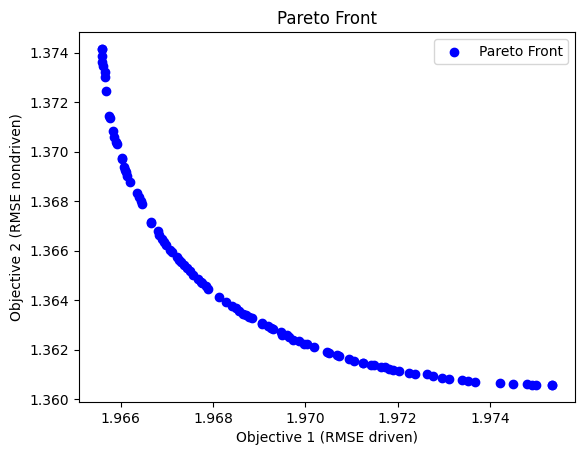

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Function to calculate Mean Bias Error (MBE)
def calculate_mbe(simulated, observed):
    return np.mean(simulated - observed)

# Calculate MBE for the driven and non-driven parts
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]
P = rainfall[730:]

mbe_driven = calculate_mbe(Y_sim[P > 0], Y_obs[P > 0])
mbe_nondriven = calculate_mbe(Y_sim[P == 0], Y_obs[P == 0])

print(f"Mean Bias Error (Driven): {mbe_driven}")
print(f"Mean Bias Error (Non-Driven): {mbe_nondriven}")

# Create the problem instance
class HydrologicalModelProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7, n_obj=2, n_constr=0, xl=np.array([1, 10, 0, 0, 0, 0.1, 0.1]), xu=np.array([10, 1000, 100, 1, 1, 10, 150]))
        
    def _evaluate(self, x, out, *args, **kwargs):
        F1 = []
        F2 = []
        for i in range(len(x)):
            params = ModelParameters(*x[i])
            solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
            Q_sim = solution.y[4]
            Y_sim = Q_sim[730:]
            Y_obs = discharge[730:]
            P = rainfall[730:]
            F1.append(calculate_rmse(Y_sim, Y_obs, P > 0))
            F2.append(calculate_rmse(Y_sim, Y_obs, P == 0))
        out["F"] = np.column_stack([F1, F2])

problem = HydrologicalModelProblem()

# Configure the NSGA-II algorithm with a population size of 100 and 250 generations
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Perform the optimization
res = minimize(problem, algorithm, ('n_gen', 250), verbose=True)

# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Plot the Pareto front in the objective function space
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', c='b')
plt.xlabel('Objective 1 (RMSE driven)')
plt.ylabel('Objective 2 (RMSE nondriven)')
plt.legend()
plt.title('Pareto Front')
plt.show()

# Normalize the parameter ranges for visualization
parameter_labels = ['Imax', 'Sumax', 'Qsmax', 'aE', 'aF', 'Kf', 'Ks']
normalized_pareto_solutions = (pareto_solutions - np.array([1, 10, 0, 0, 0, 0.1, 0.1])) / np.array([9, 990, 100, 1, 1, 9.9, 149.9])

# Plot the normalized parameter ranges similar to Fi


In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions (increased further)
initial_conditions = np.ones(5) * 1e-2

# Define the hmodel
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    # Model equations based on the schematic representation
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate Mean Bias Error (MBE)
def calculate_mbe(simulated, observed):
    return np.mean(simulated - observed)

# Calculate MBE for the driven and non-driven parts
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]
P = rainfall[730:]

mbe_driven = calculate_mbe(Y_sim[P > 0], Y_obs[P > 0])
mbe_nondriven = calculate_mbe(Y_sim[P == 0], Y_obs[P == 0])

print(f"Mean Bias Error (Driven): {mbe_driven}")
print(f"Mean Bias Error (Non-Driven): {mbe_nondriven}")


Mean Bias Error (Driven): 17162.39895615944
Mean Bias Error (Non-Driven): 17335.362941075095
